# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [19]:
# Importing all packages.

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif as mic
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

# EDA (Exploratory Data Analysis)

In [8]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [10]:
df.shape

(50000, 14)

In [11]:
df.booking_complete.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [12]:
#checking for datatypes

df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

# Mutual Information

In [13]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [14]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [15]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.051369
booking_origin           0.049455
flight_duration          0.015119
wants_extra_baggage      0.009850
length_of_stay           0.008850
wants_preferred_seat     0.005871
wants_in_flight_meals    0.003138
flight_hour              0.002949
num_passengers           0.002531
trip_type                0.002275
purchase_lead            0.000035
sales_channel            0.000000
flight_day               0.000000
Name: MI Scores, dtype: float64

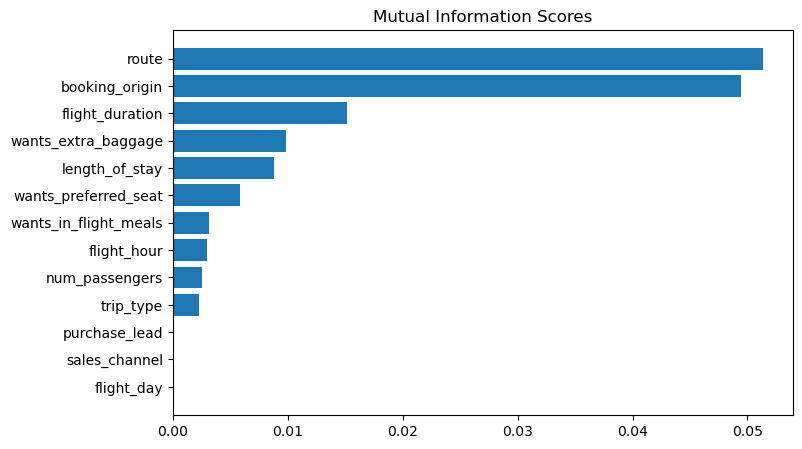

In [17]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [20]:
# Categorical columns.
cat_cols = df.select_dtypes("object")

In [21]:
# Label Encoding the categorical variables.
label_encode = LabelEncoder()

for col in cat_cols:
    df[col] = label_encode.fit_transform(df[col])
    print("\nUnique values for column '{}':".format(col))
    print(df[col].unique(), "\nUnique count: {}".format(df[col].nunique()))



Unique values for column 'sales_channel':
[0 1] 
Unique count: 2

Unique values for column 'trip_type':
[2 0 1] 
Unique count: 3

Unique values for column 'route':
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  36  37  38
  39  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 121 122 125 126 127 129 130 131 132 133 134 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 157 158 159 160 161 162 163 165 166 167 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 185 187 188 189 190 192 193 194 195 196 197
 198 199 200 202 203 204 205 207 208 209 210 212 213 214 217 218 220 221
 222 223 224 226 228 230 231 232

In [22]:
# Checking the datatypes of converted columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  int64  
 2   trip_type              50000 non-null  int64  
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  int64  
 8   booking_origin         50000 non-null  int64  
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 5.3 MB


In [23]:
df.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,0.112360,1.987620,84.940480,23.04456,9.06634,3.814420,391.905800,38.263340,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,0.315812,0.129873,90.451378,33.88767,5.41266,1.992792,227.297259,32.756539,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,0.000000,2.000000,21.000000,5.00000,5.00000,2.000000,203.000000,4.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,0.000000,2.000000,51.000000,17.00000,9.00000,4.000000,381.000000,37.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,0.000000,2.000000,115.000000,28.00000,13.00000,5.000000,611.000000,57.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,1.000000,2.000000,867.000000,778.00000,23.00000,7.000000,798.000000,103.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [24]:
# Converting the dataset into features and label.
X = df.drop("booking_complete", axis=1)
y = df["booking_complete"]

## Feature Importance
We will use Mutual Information to calculate feature importance scores for all the features in our dataset. It calculates the mutual information value for each of the independent variables with respect to the dependent variable and selects the ones which have the most information gain. In other words, it basically measures the dependency of features with the target value. A higher score means more dependent variables.



In [25]:
# Calculating the Mutual Information Scores.
fi_scores = mic(X, y)
fi_df = pd.DataFrame({"Columns": X.columns, "Feature_Importance_Score": fi_scores})
fi_df = fi_df.sort_values(by="Feature_Importance_Score", ascending=False)
fi_df

,Columns,Feature_Importance_Score
7,route,0.053359
8,booking_origin,0.045351
12,flight_duration,0.016027
4,length_of_stay,0.009693
9,wants_extra_baggage,0.009055
2,trip_type,0.006184
11,wants_in_flight_meals,0.002731
6,flight_day,0.002348
0,num_passengers,0.001956
10,wants_preferred_seat,0.001336


### Data Vizualization: Feature Importance Barplot

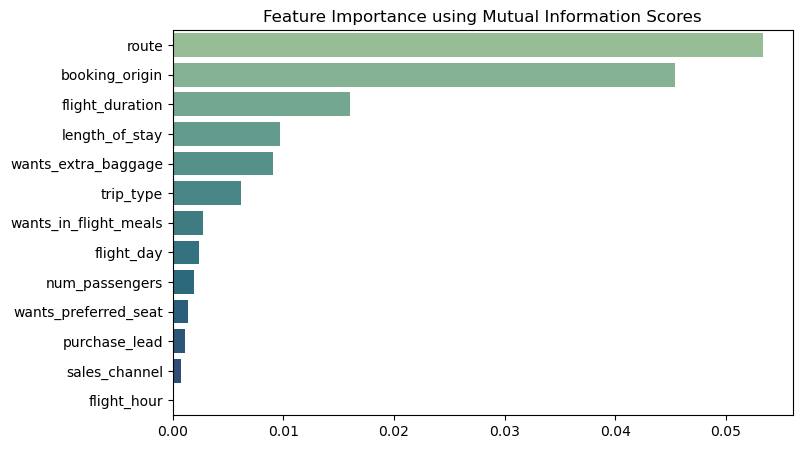

In [26]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Feature_Importance_Score", y="Columns", data=fi_df, palette="crest")
plt.title("Feature Importance using Mutual Information Scores")
plt.xlabel("")
plt.ylabel("")
plt.show()

### Model Training and Cross-Validation


In [ ]:
# Function to split the data into training and validation set.
def train_val_split(X, y):
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=7)
    return train_X, val_X, train_y, val_y

# Function to select the top-n or all the features from data.
def selecting_top_n_or_all_features(n=5):
    if str(n).lower() == "all":
        X = df[list(fi_df.Columns)]
    else:
        X = df[list(fi_df.Columns[:n])]
    # One-Hot-Encoding the variables which were Categorical variables prior to Label-Encoding.
    for col in X.select_dtypes("int32"):
        X = pd.get_dummies(X, columns=[col])
    return X

# Function to fit the data on RandomForestClassifier and product training and validation scores.
def fit_rfc(top_n):
    X = selecting_top_n_or_all_features(top_n)
    train_X, val_X, train_y, val_y = train_val_split(X, y)

    # Normalizing the Dataset.
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    
    model = RandomForestClassifier(random_state=7)
    model.fit(train_X, train_y)
    
    train_y_pred = model.predict(train_X)
    val_y_pred = model.predict(val_X)
    
    print("Training Accuracy Score:", accuracy_score(train_y, train_y_pred))
    print("Validation Accuracy Score:", accuracy_score(val_y, val_y_pred))


In [29]:
print("\n===== Model Evaluation for Top-6 features =====\n")
fit_rfc(6)


===== Model Evaluation for Top-6 features =====

Training Accuracy Score: 0.907575
Validation Accuracy Score: 0.8298


In [30]:
print("\n===== Model Evaluation for All features =====\n")
fit_rfc("all")


===== Model Evaluation for All features =====

Training Accuracy Score: 0.9998
Validation Accuracy Score: 0.8538
